## Import Libraries

In [2]:
from numpy import argmax
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
# from model import CNN_Model
import torch.optim as optim 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

## Build Models

In [3]:
class CNN_Cat_and_Dog_Classification(nn.Module):
    def __init__(self):
        super(CNN_Cat_and_Dog_Classification, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=32,  kernel_size=3,  stride=1,  padding=0)   # (img_dim - kernel_size + 2*padding)//stride +  1  ===>  (224 - 3 + 2(0) )/2 +1  = 111.5 (out_1)  .. # out_1 / pooling = 111//2 = 55                                                                                                 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,  kernel_size=3,  stride=1,  padding=0)   # (55   - kernel_size + 2*padding)//stride +  1  ===>  (55 - 3 + 2(0))/2 +1  = 27  (out_1)   .... # out_1 / pooling = 27//2 = 13                                         
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64,  kernel_size=3,  stride=1,  padding=0)   # (13   - kernel_size + 2*padding)//stride +  1  ===>  (13 - 3 + 2(0))/2 +1  = 6  (out_1)

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(64*25*25, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1( F.relu( self.conv1(x) ))
        x = self.pool1( F.relu( self.conv2(x) ))
        x = self.pool1( F.relu( self.conv3(x) ))

        # print(x.shape)
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        x = self.softmax(x)

        return x


## Transformations

In [7]:
transforms_train = transforms.Compose([ transforms.Grayscale(),
                                        transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(p=0.4), 
                                        transforms.RandomRotation(30), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.5], std=[0.5])
                                      ])

transforms_test  = transforms.Compose([ transforms.Grayscale(), 
                                        transforms.Resize((224, 224)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.5], std=[0.5])
                                      ])

## Load Datasets from Folder

In [8]:
path = "C:/Users/zorve/OneDrive/Documents/github datasets/cat_vs_dog/"

datasets_train = datasets.ImageFolder(root= path + 'train', transform=transforms_train)
datasets_test  = datasets.ImageFolder(root= path + 'test',  transform=transforms_test) 

dataloader_train = DataLoader(dataset=datasets_train, batch_size=32, shuffle=True)
dataloader_test  = DataLoader(dataset=datasets_test,  batch_size=32, shuffle=True)

## Instantiate Model, Loss Function, and Activation Function

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

model = CNN_Cat_and_Dog_Classification()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Train Model 

In [12]:
epochs, all_train_losses, all_test_losses, all_accuracies = 10, [], [], []

for epoch in range(epochs):
    losses_train, losses_test, accuracies_test, another_accuracy = 0, 0, 0, 0
    for index_data, (features_train, target_train) in enumerate(iter(dataloader_train)):

        features_train = features_train.to(device)
        target_train = target_train.to(device)

        optimizer.zero_grad()
        prediction_train = model.forward(features_train)
        loss_train = criterion(prediction_train, target_train)
        loss_train.backward()
        optimizer.step()

        losses_train += loss_train.item()

    average_losses_train = losses_train/len(dataloader_train)
    all_train_losses.append(average_losses_train)

    model.eval()
    with torch.no_grad():
        for index_data, (features_test, target_test) in enumerate(iter(dataloader_test)):

            features_test = features_test.to(device)
            target_test   = target_test.to(device)

            prediction_test = model.forward(features_test)
            loss_test = criterion(prediction_test, target_test)

            losses_test += loss_test.item()

            prediction_class = torch.argmax(prediction_test, dim=1)
            accuracies_test += accuracy_score(prediction_class, target_test)

            another_accuracy += (prediction_class == target_test).sum() / len(dataloader_test)         
        average_another_loss = another_accuracy/len(dataloader_test)

        average_losses_test = losses_test/len(dataloader_test)
        all_test_losses.append(average_losses_test)

        average_accuracy_test = accuracies_test/len(dataloader_test)
        all_accuracies.append(average_accuracy_test)

    model.train()

    print(f'{epoch+1:3}/{epochs} :  Train Loss : {average_losses_train:.6f}  |  Test Loss : {average_losses_test:.6f}  | Accuracy : {average_accuracy_test:.6f}   |  Another Accuracy : {average_another_loss:.6f}')
      

  1/10 :  Train Loss : 0.692618  |  Test Loss : 0.690938  | Accuracy : 0.513542   |  Another Accuracy : 1.510000
  2/10 :  Train Loss : 0.691006  |  Test Loss : 0.689110  | Accuracy : 0.536458   |  Another Accuracy : 1.550000
  3/10 :  Train Loss : 0.684792  |  Test Loss : 0.693225  | Accuracy : 0.564583   |  Another Accuracy : 1.690000
  4/10 :  Train Loss : 0.674336  |  Test Loss : 0.681766  | Accuracy : 0.565625   |  Another Accuracy : 1.710000
  5/10 :  Train Loss : 0.658533  |  Test Loss : 0.656176  | Accuracy : 0.642708   |  Another Accuracy : 1.890000
  6/10 :  Train Loss : 0.639802  |  Test Loss : 0.652499  | Accuracy : 0.638542   |  Another Accuracy : 1.910000
  7/10 :  Train Loss : 0.633046  |  Test Loss : 0.683420  | Accuracy : 0.560417   |  Another Accuracy : 1.710000
  8/10 :  Train Loss : 0.644767  |  Test Loss : 0.655320  | Accuracy : 0.573958   |  Another Accuracy : 1.670000
  9/10 :  Train Loss : 0.619238  |  Test Loss : 0.656174  | Accuracy : 0.622917   |  Another Acc

## Save Model

In [13]:
torch.save({"model_state": model.state_dict(), "input_size": 28*28}, 'new_trained_model')

## Plot Training Results

In [ ]:
plt.plot(all_train_losses, label='Training Losses')
plt.plot(all_test_losses,  label='Testing Lossess')
plt.plot(all_accuracies,   label='Accuracy')
plt.show()

## Load Trained Model

In [6]:
trained_model = torch.load('new_trained_model')
model_state = trained_model['model_state']

model = CNN_Cat_and_Dog_Classification()
model.load_state_dict(model_state)

<All keys matched successfully>

## Make Predictions

In [7]:
# from tkinter import Image
from PIL import ImageTk, Image

preprocessor  = transforms.Compose([ transforms.Grayscale(), 
                                        transforms.Resize((224, 224)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.5], std=[0.5])
                                      ])

image_path = "C:/Users/zorve/OneDrive/Documents/github datasets/cat_vs_dog/test/cat/cat.4003.jpg"

image = Image.open(image_path)
image = preprocessor(image)
image = image.view(1, *image.shape)

def get_prediction(image, model, classes_dict):
     model.eval()
     with torch.no_grad():
          probs = torch.exp(model(image))
          prob, pred = torch.max(probs, dim=1)
          print(f'This image is a {classes_dict[pred.item()]}  [{prob.item() * 100}]')

classes_dict = {0: 'cat', 1: 'dog'}

get_prediction(image, model, classes_dict)

This image is a cat  [179.60070371627808]


In [8]:
image_path = "C:/Users/zorve/OneDrive/Documents/github datasets/cat_vs_dog/test/dog/dog.4025.jpg"

image = Image.open(image_path)
image = preprocessor(image)
image = image.view(1, *image.shape)

def get_prediction(image, model, classes_dict):
     model.eval()
     with torch.no_grad():
          probs = torch.exp(model(image))
          prob, pred = torch.max(probs, dim=1)
          print(f'This image is a {classes_dict[pred.item()]}  [{prob.item() * 100}]')

classes_dict = {0: 'cat', 1: 'dog'}

get_prediction(image, model, classes_dict)

This image is a dog  [244.95604038238525]


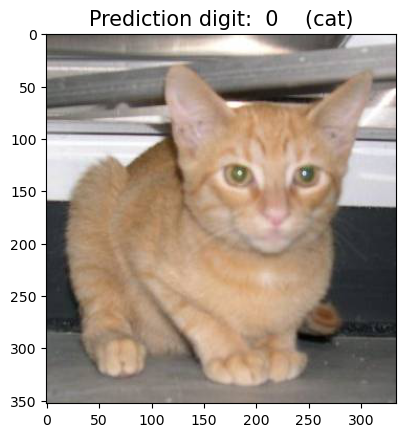

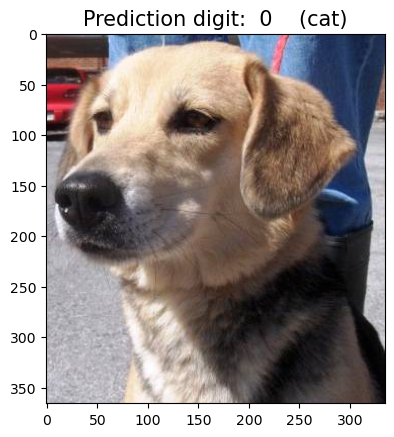

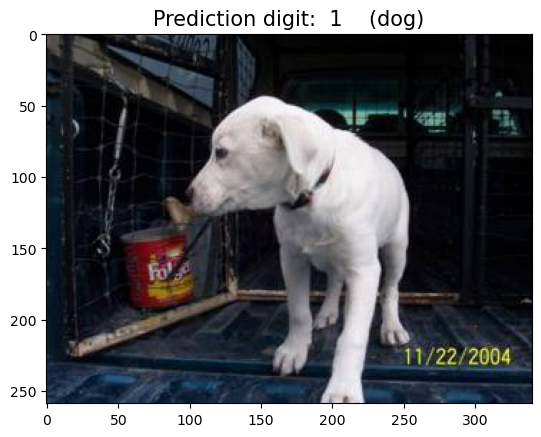

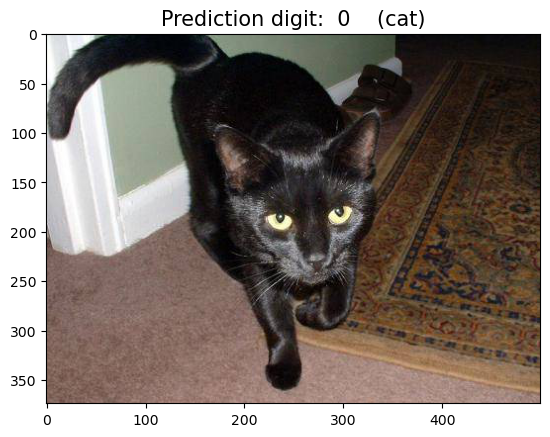

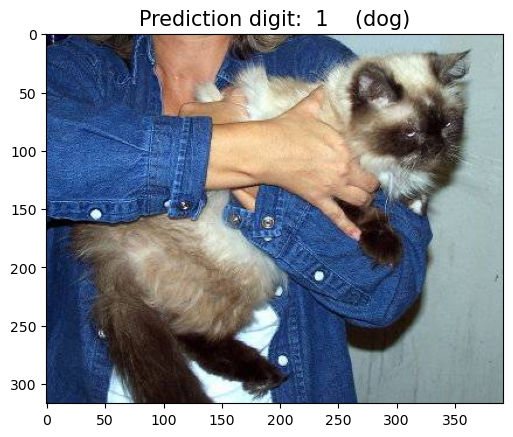

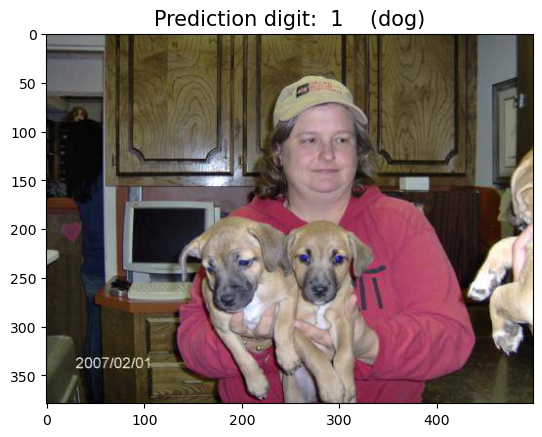

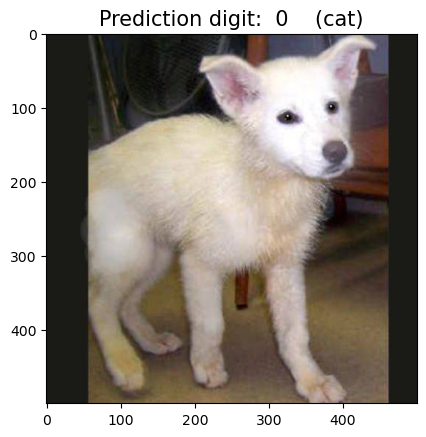

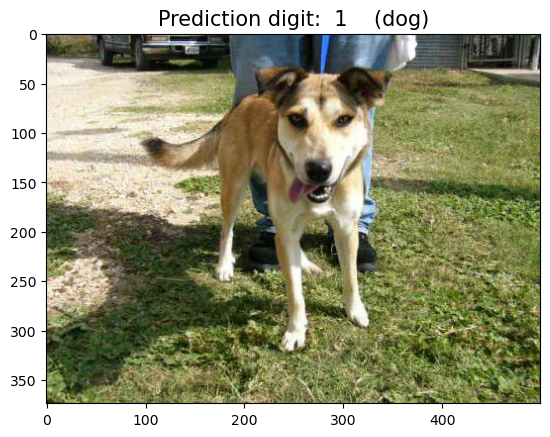

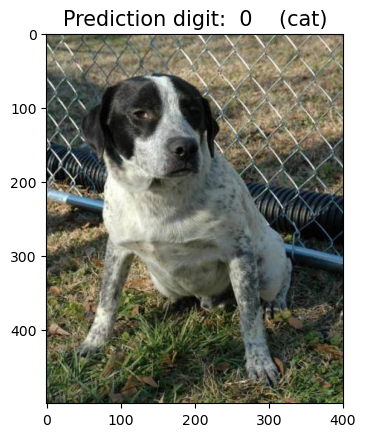

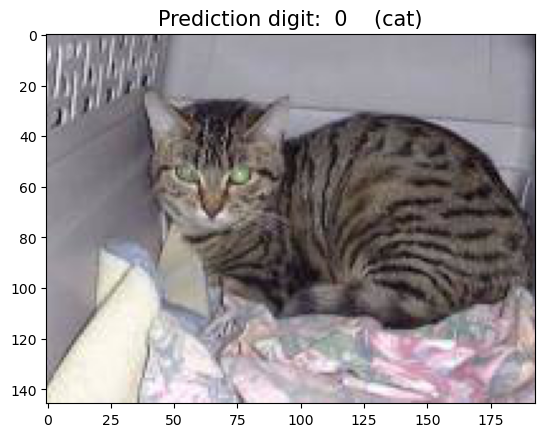

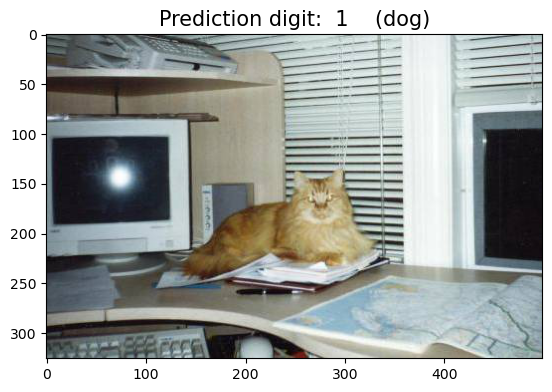

In [10]:
def make_predict(image_path, model):
     preprocessor  = transforms.Compose([ transforms.Grayscale(), transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])
                                      ])
     classes_dict = {0: 'cat', 1: 'dog'}

     image = Image.open(image_path)
     processed_image = preprocessor(image)
     processed_image = processed_image.view(1, *processed_image.shape)

     model.eval()
     with torch.no_grad():
          prediction = model.forward(processed_image)
          _, prediction_class = torch.max(prediction, dim=1)

     plt.imshow(image, cmap='gray')
     plt.title(f'Prediction digit:  {prediction_class.item()}    ({classes_dict[prediction_class.item()]})', fontsize=15)
     plt.show()

     return

from PIL import ImageTk, Image

root_path = "C:/Users/zorve/OneDrive/Documents/github datasets/cat_vs_dog/check/img_"

for i in range(0, 11, 1):
     image_path_arg = root_path +  str(i) + ".jpg"
     image_path = image_path_arg
     make_predict(image_path, model)